In [1]:
import cvxpy as cvx

import matplotlib.pyplot as plt

import numpy as np

def generate_ellipsoid_points(M, num_points=100):
    """Generate points on a 2-D ellipsoid.

    The ellipsoid is described by the equation
    `{ x | x.T @ inv(M) @ x <= 1 }`,
    where `inv(M)` denotes the inverse of the matrix argument `M`.

    The returned array has shape (num_points, 2).
    """
    L = np.linalg.cholesky(M)
    θ = np.linspace(0, 2*np.pi, num_points)
    u = np.column_stack([np.cos(θ), np.sin(θ)])
    x = u @ L.T
    return x

In [2]:
A = np.array([[0.9, 0.6],[0, 0.8]])
B = np.array([[0],[1]])
r_x = 5
r_u = 1
Q = np.eye(2)
R = np.eye(1)
P = np.eye(2)
N = 4
A, B

(array([[0.9, 0.6],
        [0. , 0.8]]),
 array([[0],
        [1]]))

In [3]:
M = cvx.Variable((2,2),symmetric=True)

constraints = []

constraints += [M<<r_x**2 * np.eye(2)]

constraints += [cvx.bmat([[M, A@M],[M@A.T, M]])>>0]

prob = cvx.Problem(
    cvx.Maximize(cvx.log_det(M)),
    constraints
)

In [4]:
prob.solve()

4.832662985874696

In [5]:
M.value

array([[24.86408695, -1.64219805],
       [-1.64219805,  5.15770616]])

In [6]:
np.linalg.inv(M.value)

array([[0.04108258, 0.01308057],
       [0.01308057, 0.19804945]])

In [7]:
ellipsoid_XT = generate_ellipsoid_points(M.value)
ellipsoid_A_XT = np.array([A@x for x in ellipsoid_XT])

θ = np.linspace(0, 2*np.pi, 100)
ellipsoid_X = r_x*np.column_stack([np.cos(θ), np.sin(θ)])

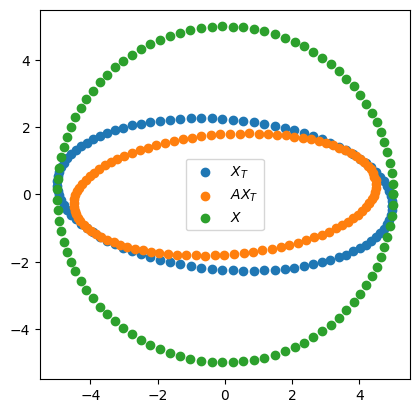

In [8]:
fig, ax = plt.subplots()
ax.scatter(ellipsoid_XT[:,0],ellipsoid_XT[:,1], label='$X_T$')
ax.scatter(ellipsoid_A_XT[:,0],ellipsoid_A_XT[:,1], label='$AX_T$')
# ax.scatter(np.array([A@x for x in ellipsoid_A_XT])[:,0],np.array([A@x for x in ellipsoid_A_XT])[:,1], label='$AAX_T$')
ax.scatter(ellipsoid_X[:,0],ellipsoid_X[:,1], label='$X$')
ax.legend()
ax.set_aspect('equal')

## The MPC Problem

In [9]:
x0 = np.array([[0],[-4.5]])
x0_cvx = cvx.Parameter((2,1), value=x0)

n, m = Q.shape[0], R.shape[0]

W = np.linalg.inv(M.value)

# Form the CVX Problem
cost = 0.0
constraints = []

x_cvx = cvx.Variable((N + 1, n))
u_cvx = cvx.Variable((N, m))

# Define Cost
cost += cvx.QuadForm(x_cvx[-1,:], P)
for i in range(N):
    cost += cvx.QuadForm(x_cvx[i,:], Q)
    cost += cvx.QuadForm(u_cvx[i,:], R)

# Define Constraints
constraints += [cvx.QuadForm(x_cvx[-1,:], W)<=1]  # Contraint x.T * M^-1 * x < 1
constraints += [cvx.norm(x_cvx[i,:], 2)<=r_x for i in range(N)]
constraints += [cvx.norm(u_cvx[i,:], 2)<=r_u for i in range(N)]
constraints += [ x_cvx[i+1,:] == A @ x_cvx[i,:] + B @ u_cvx[i,:] for i in range(N)]
constraints += [x_cvx[0,:]==x0_cvx[:,0]]


prob = cvx.Problem(cvx.Minimize(cost), constraints)
prob.solve()

/home/qdeng/.pyenv/versions/3.12.1/envs/AA203/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


86.31905795612

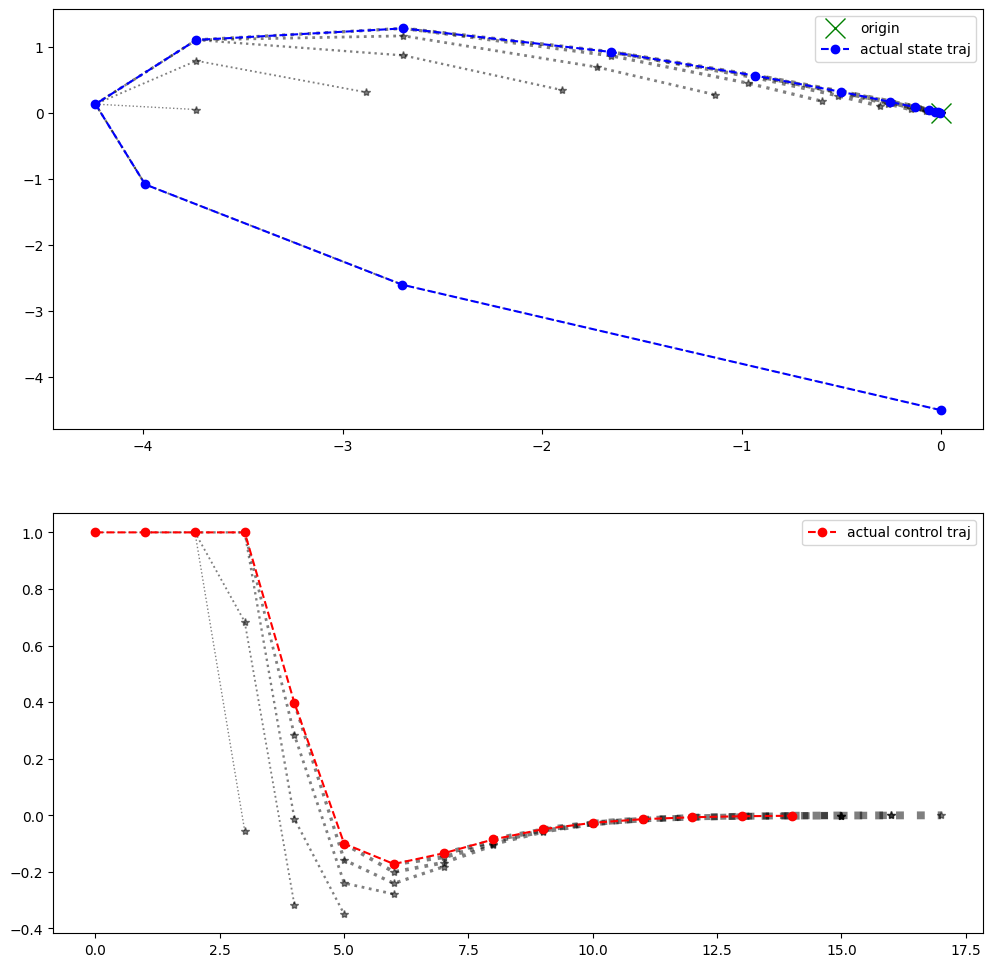

In [11]:
T = 15
x0_cvx.value = x0
x_mpc = np.zeros((T, N + 1, n))
u_mpc = np.zeros((T, N, m))

fig, ax = plt.subplots(2,1, figsize=(12, 12))

for t in range(T):
    prob.solve()

    x_mpc[t] = x_cvx.value
    u_mpc[t] = u_cvx.value

    # set the parameter value to where the state is at the next time instance
    x0_cvx.value = A @ x0_cvx.value + B * u_mpc[t, 0, :]

    # Plot out the optimized trajectory for the horizon with length N
    ax[0].plot(x_mpc[t,:,0], x_mpc[t,:,1], 'k*:', linewidth=t*1/3+1, alpha=1/2)
    ax[1].plot(t+np.arange(0,N), u_mpc[t,:,0], 'k*:', linewidth=t*1/3+1, alpha=1/2)

ax[0].plot(0,0,'gx',label='origin',markersize=15)
ax[0].plot(x_mpc[:,0,0], x_mpc[:,0,1], 'bo--', label='actual state traj')
ax[0].legend()


ax[1].plot(u_mpc[:,0,0], 'ro--', label='actual control traj')
ax[1].legend()
   